In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor, Resize, Compose, RandomHorizontalFlip, RandomRotation
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from torchsummary import summary

import pandas as pd
from pathlib import Path
import os
from PIL import Image
from tqdm import tqdm
import numpy as np
import cv2
from matplotlib import cm

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/AC297R/images_new/scores-scaled-combined.csv')
df_lmm = df.copy()

In [ ]:
# sort each row according to timestamp group by id
sorted_ids = []
for i in [1,2,3,4,5]:
  s = df_lmm[df_lmm['Id'] == i].sort_values('Timestamp (From Photo)(MMDD-YYYY-HHMMSS)')
  sorted_ids.append(s)
df_tsorted = pd.concat(sorted_ids, ignore_index=True)

In [ ]:
# Process each median  (1/0 above or below median)
score_cols = ['scores_xuliang', 'scores_siqiao', 'scores_joslyn', 'scores_shuheng', 'scores_siqi']

for col in score_cols:
  df_tsorted[col+'_post_median'] = df_tsorted[['Id', col]].groupby(['Id']).apply(lambda x: x[col] >= x[col].median()).reset_index(drop=True).astype(float)

df_tsorted

,Timestamp (From Photo)(MMDD-YYYY-HHMMSS),Id,Image Id(Id-Timestamp),Temperature (°F),"Activity Level (Categorical), i.e none, light, intense",Applied Lotion/Makeup\n(Boolean),Intervention\n(Boolean),Unnamed: 7,scores_siqiao,scores_siqi,scores_shuheng,scores_xuliang,scores_joslyn,scores_xuliang_post_median,scores_siqiao_post_median,scores_joslyn_post_median,scores_shuheng_post_median,scores_siqi_post_median
0,1015-2022-134230,1,1-1015-2022-134230.jpg,78,None,False,FALSE,NaN,0.571429,0.60,0.500000,0.142857,0.500,0.0,1.0,1.0,1.0,1.0
1,1015-2022-174630,1,1-1015-2022-174630.jpg,78,None,False,FALSE,NaN,0.857143,1.00,0.666667,0.571429,0.500,1.0,1.0,1.0,1.0,1.0
2,1015-2022-232914,1,1-1015-2022-232914.jpg,78,None,False,FALSE,NaN,0.571429,0.40,0.166667,0.428571,0.250,0.0,1.0,0.0,0.0,0.0
3,1016-2022-122933,1,1-1016-2022-122933.jpg,77,None,False,FALSE,NaN,0.571429,0.80,0.333333,0.714286,0.375,1.0,1.0,1.0,1.0,1.0
4,1016-2022-180003,1,1-1016-2022-180003.jpg,77,None,False,FALSE,NaN,0.428571,0.00,0.000000,0.285714,0.250,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,1029-2022-161935,5,5-1029-2022-161935.jpg,75,Light,False,TRUE,NaN,0.500000,0.75,0.500000,0.076923,0.400,0.0,1.0,1.0,1.0,1.0
251,1030-2022-012914,5,5-1030-2022-012914.jpg,75,None,True,TRUE,NaN,0.833333,1.00,0.500000,0.692308,0.800,1.0,1.0,1.0,1.0,1.0
252,1030-2022-172704,5,5-1030-2022-172704.jpg,75,None,True,TRUE,NaN,0.500000,1.00,0.750000,0.846154,0.600,1.0,1.0,1.0,1.0,1.0
253,1030-2022-204923,5,5-1030-2022-204923.jpg,75,None,False,TRUE,NaN,0.333333,0.25,0.500000,0.076923,0.800,0.0,0.0,1.0,1.0,0.0


In [ ]:
IMAGE_DIR = Path('/content/drive/Shareddrives/AC297R/images_new')

train_trans = Compose([
    Resize((224, 224)),
    ToTensor(),
])

inf_trans = Compose([
    Resize((224, 224)),
    ToTensor(),
])

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, df, inf = False, train_trans = train_trans, inf_trans = inf_trans):
        self.xs = []
        self.ys = []
        self.train_trans = train_trans
        self.inf_trans = inf_trans
        self.inf = inf

        for i, row in tqdm(df.iterrows()):
            fn = row['Image Id(Id-Timestamp)']
            im = Image.open(IMAGE_DIR / fn[0] / fn)
            if self.inf == True:
              self.xs.append(inf_trans(im))
              self.ys.append(-1)
            else:
              self.xs.append(train_trans(im))
              yy = float(np.sum([
                      row.scores_xuliang_post_median,
                      row.scores_siqiao_post_median,
                      row.scores_joslyn_post_median,
                      row.scores_shuheng_post_median,
                      row.scores_siqi_post_median
                  ]) > 2.0)
              self.ys.append(yy)
    
    def __getitem__(self, i):
        return self.xs[i], self.ys[i]

    def __len__(self):
        return len(self.xs)

In [ ]:
all_ids = [1,2,3,4,5]
train_val_ids = [2] #[1,2,3,4,5]
inf_ids = [2] #[id for id in all_ids if id not in train_val_ids] #[4]

train_val_df = pd.concat([df_tsorted[df_tsorted['Id'] == i] for i in train_val_ids], ignore_index=True)
train_val_df = train_val_df[train_val_df['Intervention\n(Boolean)'] == 'FALSE'] # Only use the no intervention data to train
inf_df = pd.concat([df_tsorted[df_tsorted['Id'] == i] for i in inf_ids], ignore_index=True)
inf_df = inf_df[inf_df['Intervention\n(Boolean)'] == 'TRUE']

In [ ]:
BATCH_SIZE = 32

train_dataset = ImageDataset(train_val_df, train_trans=train_trans)
inf_dataset = ImageDataset(inf_df, inf=True, inf_trans = inf_trans)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
inf_loader = DataLoader(inf_dataset, batch_size=BATCH_SIZE, shuffle=False)

24it [00:32,  1.36s/it]
24it [00:31,  1.31s/it]


In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=36864):
        return input.view(input.size(0), size, 1, 1)

class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=36864, z_dim=1024):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 512, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=8, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [ ]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [ ]:
#DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")
model = VAE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2) 

In [ ]:
EPOCHS = 10
for epoch in range(EPOCHS):
    for images, _ in train_loader:
        images = images.to(DEVICE)
        recon_images, mu, logvar = model(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                EPOCHS, loss.data.item()/BATCH_SIZE, bce.data.item()/BATCH_SIZE, kld.data.item()/BATCH_SIZE)
        print(to_print)

Epoch[1/10] Loss: 1.490 1.458 0.032
Epoch[2/10] Loss: 1.478 1.461 0.017
Epoch[3/10] Loss: 1.492 1.473 0.019
Epoch[4/10] Loss: 1.508 1.486 0.022
Epoch[5/10] Loss: 1.510 1.486 0.024
Epoch[6/10] Loss: 1.513 1.490 0.023
Epoch[7/10] Loss: 1.510 1.487 0.023
Epoch[8/10] Loss: 1.508 1.486 0.022
Epoch[9/10] Loss: 1.509 1.490 0.018
Epoch[10/10] Loss: 1.506 1.492 0.014


In [ ]:
train_loader_1 = DataLoader(train_dataset, batch_size=1, shuffle=True)
inf_loader_1 = DataLoader(inf_dataset, batch_size=1, shuffle=False)

train_recon_loss = []
train_kld_loss = []
with torch.no_grad():
  for images, _ in train_loader_1:
    recon_images, mu, logvar = model(images)
    _, bce, kld = loss_fn(recon_images, images, mu, logvar)
    train_recon_loss.append(bce.item())
    train_kld_loss.append(kld.item())

inf_recon_loss = []
inf_kld_loss = []
with torch.no_grad():
  for images, _ in inf_loader_1:
    recon_images, mu, logvar = model(images)
    _, bce, kld = loss_fn(recon_images, images, mu, logvar)
    inf_recon_loss.append(bce.item())
    inf_kld_loss.append(kld.item())

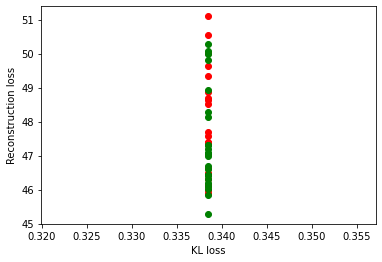

In [ ]:
plt.plot(train_kld_loss, train_recon_loss, 'ro')
plt.plot(inf_kld_loss, inf_recon_loss, 'go')
plt.xlabel('KL loss')
plt.ylabel('Reconstruction loss')
plt.show()